In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
# from torchsummary import summary
import time
import copy

In [2]:
GPU_NUM = 2
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  2
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
import torch
import torch.nn as nn

def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [4]:
from torchvision import transforms, datasets, models
import os

class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("data_set/data_set/MV_test_annotations/", file_label)
        else:
            label_path = os.path.join("data_set/data_set/MV_train_annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'data_set/data_set/MV_train_images/')
test_dataset = MaskDataset(data_transform, 'data_set/data_set/MV_test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn)

In [22]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone



# ResNet-101 백본을 불러오기
backbone = torchvision.models.resnet101(pretrained=True).to(device)
# ResNet의 마지막 fully connected layer를 제거하여 백본을 만듭니다.
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
# 새로운 Convolutional 레이어와 ReLU 활성화 함수를 추가
conv6 = nn.Conv2d(2048, 256, kernel_size=3, dilation=6, padding=6)
relu = nn.ReLU(inplace=True)

# 새로운 백본을 만들기 (ResNet-101의 마지막 4개 레이어 + 새로운 레이어)
backbone = nn.Sequential(
    *list(backbone.children()),  # ResNet의 마지막 4개 레이어
    conv6,  # 새로운 Convolutional 레이어
    relu  # ReLU 활성화 함수
)


backbone_out = 256
backbone.out_channels = backbone_out

anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((128),),aspect_ratios=((0.5, 1.0, 2.0),))

resolution = 7
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=resolution, sampling_ratio=2)

box_head = torchvision.models.detection.faster_rcnn.TwoMLPHead(in_channels= backbone_out*(resolution**2),representation_size=1024) 
box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024,2) #21개 class

model2 = torchvision.models.detection.FasterRCNN(backbone, num_classes=None,
                   min_size = 576, max_size = 1000,
                   rpn_anchor_generator=anchor_generator,
                   rpn_pre_nms_top_n_train = 6000, rpn_pre_nms_top_n_test = 6000,
                   rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=300,
                   rpn_nms_thresh=0.7,rpn_fg_iou_thresh=0.7,  rpn_bg_iou_thresh=0.3,
                   rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                   box_roi_pool=roi_pooler, box_head = box_head, box_predictor = box_predictor,
                   box_score_thresh=0.05, box_nms_thresh=0.7,box_detections_per_img=300,
                   box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                   box_batch_size_per_image=128, box_positive_fraction=0.25
                 ).to(device)
#roi head 있으면 num_class = None으로 함

# for param in model.rpn.parameters():
#   torch.nn.init.normal_(param,mean = 0.0, std=0.01)

# for name, param in model.roi_heads.named_parameters():
#     if "bbox_pred" in name:
#         torch.nn.init.normal_(param,mean = 0.0, std=0.001)
#     elif "weight" in name:
#         torch.nn.init.normal_(param,mean = 0.0, std=0.01)
#     if "bias" in name:
#         torch.nn.init.zeros_(param)

In [10]:
import torch


# 저장된 모델 파라미터 파일 경로
model_path = 'Pmodel_.pth'

# 저장된 모델 파라미터 불러오기
model1.load_state_dict(torch.load(model_path))

# 모델을 평가 모드로 설정
model.eval()

# 이제 model 변수를 사용하여 예측을 수행하거나 추가 학습을 진행할 수 있습니다.


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(576,), max_size=1000, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

In [11]:
model2.backbone[0] = nn.AdaptiveAvgPool2d(output_size=(36, 48))
model2.backbone[1] = nn.Conv2d(3, 1024, kernel_size=(1, 1), stride=(1, 1))
del model2.backbone[6]
del model2.backbone[5]
del model2.backbone[4]
del model2.backbone[3]
del model2.backbone[2]

In [12]:
num_epochs = 550
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
import time
from PIL import Image
from bs4 import BeautifulSoup

print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.to(device)
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

In [13]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list].cpu()
        preds[id]['labels'] = preds[id]['labels'][idx_list].cpu()
        preds[id]['scores'] = preds[id]['scores'][idx_list].cpu()

    return preds

In [31]:
model.to(device)
model1.to(device)
model2.to(device)
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[666.8348, 210.2168, 695.9542, 293.7704],
        [278.4483, 434.6573, 331.0816, 573.3550],
        [573.1374, 205.0152, 599.6122, 284.7596],
        [447.0145, 304.0365, 481.5672, 415.4805],
        [637.6471, 308.3922, 667.3739, 405.0156],
        [196.2499, 150.5820, 219.5780, 215.6305]]), 'labels': tensor([1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9998, 0.9997, 0.9997, 0.9997, 0.9996, 0.9996])}, {'boxes': tensor([[283.8163, 438.5364, 335.2435, 572.6788],
        [636.6741, 307.5641, 667.8004, 405.7942],
        [674.8387, 213.6339, 701.7568, 294.1721],
        [563.8549, 201.5002, 591.1240, 282.2188],
        [187.2625, 147.5019, 213.8300, 213.5357],
        [459.8701, 308.2160, 500.4918, 410.3006],
        [462.9914, 303.3878, 494.4921, 402.5475],
        [190.2673, 152.3691, 219.7935, 216.1737],
        [464.1844, 288.0768, 499.4271, 398.7256]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9998, 0.9997, 0.9995, 0.9990, 0.9989, 0.9988, 0.965

Target :  tensor([1, 1, 1, 1, 1, 1, 1])


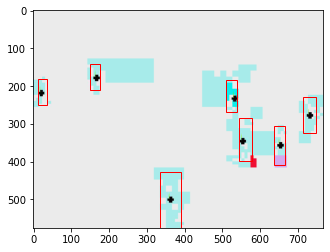

Prediction :  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])


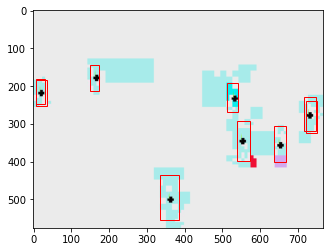

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

_idx = 9
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx].cpu(), pred[_idx])

In [16]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model2, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 11/11 [00:11<00:00,  1.00s/it]


In [17]:
import torch
import numpy as np

def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']

        true_positives = torch.zeros(output['boxes'].shape[0])   # 예측 객체 개수
 
        annotations = targets[sample_i]  # actual
        target_labels = annotations['labels'] if len(annotations) else []
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): # 예측값에 대해서..

                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: # iou만 맞으면 통과?
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 예측된거랑 실제랑 매핑해서 하나씩 index 채움
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   # 2가 거의 예측안됨

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [33]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.0
AP : tensor([0.], dtype=torch.float64)


In [ ]:
# import torch


# # 모델 파라미터 저장
# torch.save(model3.state_dict(), 'Pmodel_Bmodel.pth')

In [19]:
import torch


# 저장된 모델 파라미터 파일 경로
model_path = 'Pmodel_.pth'

# 저장된 모델 파라미터 불러오기
model.load_state_dict(torch.load(model_path))


# 이제 model 변수를 사용하여 예측을 수행하거나 추가 학습을 진행할 수 있습니다.


<All keys matched successfully>

In [20]:
import torch


# 저장된 모델 파라미터 파일 경로
model_path = 'Pmodel_Bmodel.pth'

# 저장된 모델 파라미터 불러오기
model1.load_state_dict(torch.load(model_path))



# 이제 model 변수를 사용하여 예측을 수행하거나 추가 학습을 진행할 수 있습니다.


<All keys matched successfully>

In [23]:
import torch
import torch.nn as nn

# model1과 model을 불러옵니다.


# detector 파라미터 추출
model1_detector_params = model1.roi_heads.state_dict()
model_detector_params = model.roi_heads.state_dict()

# detector 파라미터 평균 계산
ensemble_detector_params = {}
for key in model1_detector_params:
    ensemble_detector_params[key] = (model1_detector_params[key] + model_detector_params[key]) / 2

# 새로운 앙상블 모델을 정의하고 detector 파라미터 적용
model3.roi_heads.load_state_dict(ensemble_detector_params)

# 이제 ensemble_model을 사용하여 앙상블 검출을 수행할 수 있습니다.


<All keys matched successfully>

In [24]:
# model1에서 백본 모델 파라미터 가져오기
backbone_params = model3.roi_heads.state_dict()

# model의 백본 파라미터에 복사
model2.roi_heads.load_state_dict(backbone_params)



<All keys matched successfully>

In [25]:
# model1에서 백본 모델 파라미터 가져오기
backbone_params = model1.roi_heads.state_dict()

# model의 백본 파라미터에 복사
model.roi_heads.load_state_dict(backbone_params)


<All keys matched successfully>